<a href="https://colab.research.google.com/github/dpanagop/re-identification/blob/master/min_viable_example/minimum_viable_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://github.com/dpanagop/re-identification/raw/master/min_viable_example/min_viable_dependencies.zip \
    -O /tmp/min_viable_dependencies.zip

--2019-04-23 18:59:11--  https://github.com/dpanagop/re-identification/raw/master/min_viable_example/min_viable_dependencies.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dpanagop/re-identification/master/min_viable_example/min_viable_dependencies.zip [following]
--2019-04-23 18:59:11--  https://raw.githubusercontent.com/dpanagop/re-identification/master/min_viable_example/min_viable_dependencies.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3251336 (3.1M) [application/zip]
Saving to: ‘/tmp/min_viable_dependencies.zip’

/tmp/min_viable_dep 100%[===================>]   

In [2]:
!wget --no-check-certificate \
    https://github.com/dpanagop/re-identification/raw/master/min_viable_example/ssd_mobilenet_v1_coco_2017_11_17.zip \
    -O /tmp/ssd_mobilnet.zip

--2019-04-23 18:59:24--  https://github.com/dpanagop/re-identification/raw/master/min_viable_example/ssd_mobilenet_v1_coco_2017_11_17.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dpanagop/re-identification/master/min_viable_example/ssd_mobilenet_v1_coco_2017_11_17.zip [following]
--2019-04-23 18:59:24--  https://raw.githubusercontent.com/dpanagop/re-identification/master/min_viable_example/ssd_mobilenet_v1_coco_2017_11_17.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25433851 (24M) [application/zip]
Saving to: ‘/tmp/ssd_mobilnet.zip’

/tmp/ssd_mobilnet.z 100%[========

In [0]:
import os
os.chdir('/')

In [0]:
import zipfile

local_zip = '/tmp/min_viable_dependencies.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
local_zip = '/tmp/ssd_mobilnet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [0]:
import numpy as np
import tarfile
import tensorflow as tf

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO

from PIL import Image
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

import cv2
  
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import imutils

try:
    from google.colab.patches import cv2_imshow
    IN_COLAB=True
except:
    IN_COLAB = False

In [0]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS ='mscoco_label_map.pbtxt' 


In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# DP main inference function not changed
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
# DP function for storing image and boxes
def save_boxes(image_np, output_dict,name,orig_np=np.array([]),path=''):
    image_name=os.path.join(path,name+'.jpg')
    cv2.imwrite(image_name,image_np)
    boxes=output_dict['detection_boxes'][(output_dict['detection_scores']>0.8) & (output_dict['detection_classes']==1)]
    for idx,rect in  enumerate(boxes):
        print(idx, rect)
        im_height,im_width,im_depth = image_np.shape
        ymin, xmin, ymax, xmax= rect  
        (top, bottom,left, right ) = (int(round(ymin * im_height)), int(round(ymax * im_height)), 
                              int(round(xmin * im_width)), int(round(xmax * im_width)))
        image_name=os.path.join(path,name+'_box_'+str(idx+1)+'.jpg')
        if orig_np.size==0:
             cv2.imwrite(image_name,image_np[top:bottom,left:right])
        else:
             cv2.imwrite(image_name,orig_np[top:bottom,left:right])
        print('Saved '+image_name)

In [12]:
model = tf.contrib.saved_model.load_keras_model("./min_example/saved_models/1555146896")
model.summary()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 598, 98, 16)       448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 6, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 4, 32)         4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 2, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (No

In [13]:
print(os.getcwd())
PATH_TO_TEST_IMAGES_DIR = 'min_example' #test_images'
imagelist=os.listdir(PATH_TO_TEST_IMAGES_DIR)
print(imagelist)
imagelist=[s for s in imagelist if s.find('_1.png') != -1]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,s ) for s in imagelist ]
print(TEST_IMAGE_PATHS)

/
['to_test', 'IFWN-sequence-035_2_test.png', 'saved_models', 'min example README.txt', 'IFWN-sequence-035_1.png', 'IFWN-sequence-036_1.png', 'persons']
['min_example/IFWN-sequence-035_1.png', 'min_example/IFWN-sequence-036_1.png']


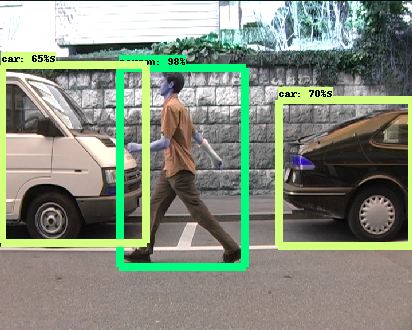

0 [0.20822346 0.29072267 0.8085606  0.5961588 ]
Saved min_example/persons/IFWN-sequence-035_1.png_box_1.jpg


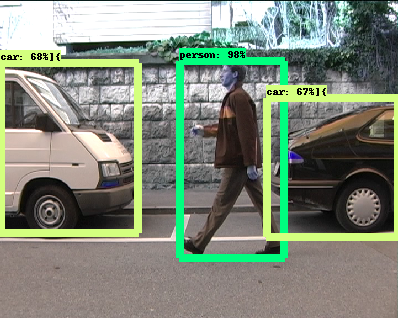

0 [0.19187546 0.4520335  0.80838597 0.7150377 ]
Saved min_example/persons/IFWN-sequence-036_1.png_box_1.jpg


In [17]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # DP copy image so that we can save boxes without line
  orig_np = image_np.copy()
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  # DP matplotlib as plt is repalced by cv2 (see comments at Imports section)
  # plt.figure(figsize=IMAGE_SIZE)
  # plt.imshow(image_np)
  image_name=os.path.relpath(image_path,PATH_TO_TEST_IMAGES_DIR)
  image_name=image_name.replace('.jpg','')
  if IN_COLAB== True:
     cv2_imshow(image_np)
  else:
     cv2.imshow(image_name,image_np)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  # DP the following two lines store image and cropped boxes to disc
  save_boxes(image_np,output_dict,image_name,orig_np,path='min_example/persons')

In [18]:
PATH_TO_TEST_IMAGES_DIR = 'min_example' #test_images'
imagelist=os.listdir(PATH_TO_TEST_IMAGES_DIR)
imagelist=[s for s in imagelist if s.find('_test.png') != -1]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR,s ) for s in imagelist ]
print(TEST_IMAGE_PATHS)

['min_example/IFWN-sequence-035_2_test.png']


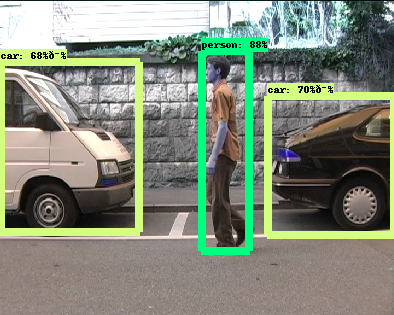

0 [0.16300303 0.51072544 0.79445434 0.63390356]
Saved min_example/to_test/IFWN-sequence-035_2_test.png_box_1.jpg


In [19]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # DP copy image so that we can save boxes without line
  orig_np = image_np.copy()
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  # DP matplotlib as plt is repalced by cv2 (see comments at Imports section)
  # plt.figure(figsize=IMAGE_SIZE)
  # plt.imshow(image_np)
  image_name=os.path.relpath(image_path,PATH_TO_TEST_IMAGES_DIR)
  image_name=image_name.replace('.jpg','')
  if IN_COLAB==True:
      cv2_imshow(image_np) 
  else:
      cv2.imshow(image_name,image_np)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  # DP the following two lines store image and cropped boxes to disc
  save_boxes(image_np,output_dict,image_name,orig_np,path='min_example/to_test')

In [20]:
PATH_TO_IMAGES_DIR = os.path.join('min_example','persons')
print(PATH_TO_IMAGES_DIR)
PERSONS=os.listdir(PATH_TO_IMAGES_DIR)
print(PERSONS)
PATH_TO_IMAGES_DIR = os.path.join('min_example','to_test')
TO_TEST=os.listdir(PATH_TO_IMAGES_DIR)
print(TO_TEST)

min_example/persons
['IFWN-sequence-035_1.png.jpg', 'IFWN-sequence-036_1.png_box_1.jpg', 'IFWN-sequence-036_1.png.jpg', 'IFWN-sequence-035_1.png_box_1.jpg']
['IFWN-sequence-035_2_test.png.jpg', 'IFWN-sequence-035_2_test.png_box_1.jpg']


In [0]:
bar=np.zeros((50,100,3), dtype=np.uint8)

(642, 100, 3)
different


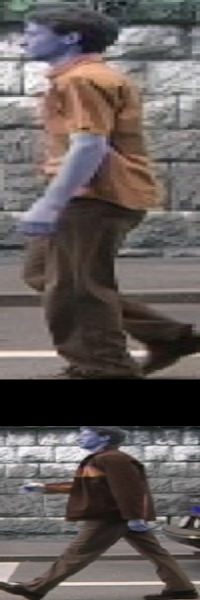

(613, 100, 3)
same


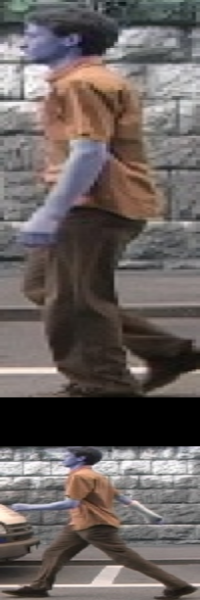

In [22]:
for image_path1 in TO_TEST:
    for image_path2 in PERSONS:
        if ((image_path1.find('_box_')!= -1) and (image_path2.find('_box_')!= -1)):
          path1=os.path.join('min_example','to_test',image_path1)
          path2=os.path.join('min_example','persons',image_path2)
          image1 = cv2.imread(path1)
          image1 = imutils.resize(image1, width=100) #min(200, image1.shape[1]))
          image2 = cv2.imread(path2)
          image2 = imutils.resize(image2, width=100) #min(200, image2.shape[1]))
          imgs_comb =np.concatenate((image1,bar, image2))
          print(imgs_comb.shape)
          imgs_comb_test=imgs_comb.copy() 
          imgs_comb_test = cv2.resize(imgs_comb_test,(100, 600))
          imgs_comb_test= np.expand_dims(imgs_comb_test, axis=0)
          imgs_comb_test = np.vstack([imgs_comb_test])
          classes = model.predict(imgs_comb_test, batch_size=10)
          if classes[0]>00.5:
            tag= "same"
          else:
            tag="different"
          print(tag)
          tmp=cv2.resize(imgs_comb,(200, 600))
          if IN_COLAB==True:
             cv2_imshow(tmp) 
          else:
             cv2.imshow(tag,tmp)
          cv2.waitKey(0)
          # cv2.destroyAllWindows()